In [1]:
from googlesearch import search
from selectorlib import Extractor
from bs4 import BeautifulSoup
import requests
import random
import pandas as pd
import copy
from pprint import pprint

In [2]:
def google_query(isbn):
    """This function receive a book's ISBN and return an amazon link by looking on Google"""
    
    query = "https://www.amazon.it"+"/"+isbn+"/"
    googleResults = []
    for result in search(query,tld="co.in",num=1,stop=1, pause=2):
        googleResults.append(result)

    return googleResults[0]

In [3]:
def get_HTML(url):
    """This function return the HTML of a given link as a string"""
    rand = float(random.randint(1,100)) # We need to randomaize the request
    headers = {
        'dnt': '1',
        'upgrade-insecure-requests': '1',
        'user-agent': 'Mozilla/' + str(rand)+ 'Macintosh; Intel Mac OS X 10_15_4) AppleWebKit/537.36 (KHTML, like Gecko)' + 'Chrome/'+ str(rand) + 'Safari/'+str(rand),
        'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
        'sec-fetch-site': 'same-origin',
        'sec-fetch-mode': 'navigate',
        'sec-fetch-user': '?1',
        'sec-fetch-dest': 'document',
        'referer': 'https://www.amazon.com/',
        'accept-language': 'en-GB,en-US;q=0.9,en;q=0.8',
    }
    
    return requests.get(url, headers=headers).text

In [4]:
def get_RevPerStar(allReviews):
    """This function build a list of each star reating link. Check what reating page
    has no reviews and givs in output a list of 5 dictionary, one per star reating, 
    that contains the information of the first review of each star reating.
    """
    
    starFilterList = ['&filterByStar=one_star&pageNumber=1',
                      '&filterByStar=two_star&pageNumber=1',
                     '&filterByStar=three_star&pageNumber=1',
                     '&filterByStar=four_star&pageNumber=1',
                     '&filterByStar=five_star&pageNumber=1']
  
    #Make a list which contains the links of each star reviews page
    allStarLinks = []
    for i in range(5):
        amazonStarLink = allReviews + starFilterList[i]
        allStarLinks.append(amazonStarLink)
    
    #Get the html page of each star reviews page
    allStars_HTML = []
    for link in allStarLinks:
        allStars_HTML.append(get_HTML(link))
    
    #Check which page has the empty feedback state
    empty_state_for_stars = []
    for starWebPage in allStars_HTML:
        soup = BeautifulSoup(starWebPage,'html.parser')
        empty_reviews_state = soup.select('.reviews-content .no-reviews-section')
        empty_state_for_stars.append(empty_reviews_state)
    
    #Make a list which contains for each star the link of feedback page if that star has reviews,
    #otherwise append 'None' for that star
    star = ['','']
    useful_starLinks = []
    
    for k in range(len(empty_state_for_stars)):
        if len(empty_state_for_stars[k]) != 0 :
            star[0] = k+1
            star[1] = None
        else:
            star[0] = k+1
            star[1] = allStarLinks[k]
        temp = copy.deepcopy(star)
        useful_starLinks.append(temp)
      
    reviews_info = {'star':'','state':'','error_msg':'','review_title':'','review_date':'', 'review_votes':'', 'review_text':''}
    
    reviewPerStar_list = []
    for elem in useful_starLinks:
        if elem[-1] == None:
            reviews_info['star'] = elem[0]
            reviews_info['state'] = 0
            reviews_info['error_msg'] = f'Non presenti recensioni per Star[{elem[0]}]'
            reviews_info['review_title'] = None
            reviews_info['review_date'] = None
            reviews_info['review_votes'] = None
            reviews_info['review_text'] = None
        else:
            htmlPage = get_HTML(elem[-1])
            soup2 = BeautifulSoup(htmlPage,'html.parser')
            firstReview_id = '#' + soup2.find('div', {"data-hook":"review"}).get('id') + '-review-card'
            
            css_reviewTitleSelector = firstReview_id + ' ' + '.review-title-content' + ' ' + 'span'
            css_reviewDateSelector = firstReview_id + ' ' + '.review-date' 
            css_reviewVotesSelector = firstReview_id + ' ' + '.cr-vote-text' 
            css_reviewTextContent = firstReview_id + ' ' + '.review-text-content' + ' ' + 'span'

            reviewTitle = soup2.select(css_reviewTitleSelector)
            reviewDate = soup2.select(css_reviewDateSelector)
            reviewVotes = soup2.select(css_reviewVotesSelector)
            reviewTextContent = soup2.select(css_reviewTextContent)
            
            #print(reviewTitle)
            #print(reviewDate)
            #print(reviewVotes)
            #print(reviewTextContent)
            
            #Get Review Title:
            reviewTitle_content = reviewTitle[0].contents
            
            #Get Review Date:
            reviewDate_content = reviewDate[0].contents
            
            #Get Review Vote if present:
            if len(reviewVotes) != 0:
                reviewVotes_content = reviewVotes[0].contents
            else:
                reviewVotes_content = 'None'
            
            #Get Review Content:
            reviewText_content = reviewTextContent[0].contents
            
            #print(reviewTitle_content[0])
            #print(reviewDate_content[0])
            #print(reviewVotes_content[0])
            #print(reviewText_content[0])
            reviews_info['star'] = elem[0]
            reviews_info['state'] = 1
            reviews_info['error_msg'] = 'None'
            reviews_info['review_title'] = reviewTitle_content[0]
            reviews_info['review_date'] = reviewDate_content[0]
            reviews_info['review_votes'] = reviewVotes_content[0]
            reviews_info['review_text'] = reviewText_content[0]
        
        tempRevInfo = reviews_info.copy()
        reviewPerStar_list.append(tempRevInfo)
            
            
    return reviewPerStar_list

In [5]:
def visualizerRevPerStar(listOfDict):
    k = len(listOfDict)-1
    while(k>=0):
        if listOfDict[k]['state'] != 0:
            #Visualize Book's Review
            print("______________________________________________________________________________________")
            print(f"\n-REVIEW FOR STAR[{listOfDict[k]['star']}]-")
            print(f"\n-DATE: {listOfDict[k]['review_date']}")
            print(f"\n-REVIEW_TITLE: {listOfDict[k]['review_title']}")
            print(f"\n-REVIEW_VOTES: {listOfDict[k]['review_votes']}")
            print("\n-REVIEW_CONTENT-------------------------------------------------------------------")
            print(listOfDict[k]['review_text'])
            print("------------------------------------------------------------------------------------\n")
        else:
            #Visualize Book's Review
            print("______________________________________________________________________________________")
            print(f"\n-THERE ARE NO REVIEWS FOR STAR[{listOfDict[k]['star']}]-")
            
        k = k-1
        

In [6]:
def get_reviewText(rawText,date,votes):
    """This function separates the review text from date and votes that are included inside the rawText"""
    
    review = rawText.split(date)[1].split(votes)[0].split('Leggi di più')[0] 
    
    return review[1:-1]

In [7]:
#-ISBN - Book with no reviews:
#ISBN = '3110689383'

#-ISBN - Book with amazon selection of best and worst reviews:
#ISBN = '8820395592'

#-ISBN - Other Book with amazon selection of best and worst reviews:
#ISBN = '1449355730'

#-ISBN - Book with NO amazon selection of best and worst reviews:
ISBN = '938984536X'


amazon_link = google_query(ISBN)
print(amazon_link)

https://www.amazon.it/Pragmatic-Machine-Learning-Python-Production/dp/938984536X


In [8]:
book_webPage = get_HTML(amazon_link)
soup = BeautifulSoup(book_webPage,'html.parser')
no_reviewsState = soup.find_all('span', {"data-hook":"top-customer-reviews-title"})
if len(no_reviewsState) != 0:
    noReviews = 1
else:
    noReviews = 0

print(noReviews)
#print(book_webPage)

0


In [9]:
# Get the link of the all reviews
if noReviews != 1:
    soup = BeautifulSoup(book_webPage,'html.parser')
    links = soup.find_all('a', {"data-hook":"see-all-reviews-link-foot"})
    allReviews_link = 'https://www.amazon.it' + links[0].get("href")
    print(allReviews_link)

https://www.amazon.it/Pragmatic-Machine-Learning-Python-Production/product-reviews/938984536X/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews


In [10]:
#Get the web page of the book's reviews
if noReviews != 1:
    reviewsPage = get_HTML(allReviews_link)

In [11]:
#Create an object extractor based on the CSS "selectors" specified into "data_selectors.yml"
e = Extractor.from_yaml_file('./data_selectors.yml')
data = e.extract(book_webPage)
#print(data)

if noReviews != 1:
    #Create an object extractor based on the CSS "selectors" specified into "review_selectors.yml"
    e_rev = Extractor.from_yaml_file('./review_selectors.yml')
    dataReviews = e_rev.extract(reviewsPage)
  

In [12]:
#Visualize Book's data:
for k,v in data.items():
    if k != 'link_to_all_reviews':
        print(f"\n-{k.upper()}: {v}")

if noReviews != 1:
    #Check if there is an Amazon selection for best and Worst reviews:
    if dataReviews['best_rw'] == None and dataReviews['worst_rw'] == None:
        print("\n_WARNING: Amazon's best and worst feedback not present. So the app just returns the first feedback of each star reating.")
        reviewsPerStar = get_RevPerStar(allReviews_link)
        visualizerRevPerStar(reviewsPerStar)
    else:
        #Parsing Reviews data:
        ### Best Positive Review Data:
        positiveReview_rowText = dataReviews['best_rw'] # Contain all the text inside the positive review "DIV"
        positiveReview_title = dataReviews['title_positive']
        positiveReview_date = dataReviews['date_positive']
        positiveReview_votes = dataReviews['review_votes_positive']

        ### Worst Critical Review Data: 
        criticalReview_rowText = dataReviews['worst_rw'] # Contain all the text inside the critical review "DIV"
        criticalReview_title = dataReviews['title_negative']
        criticalReview_date = dataReviews['date_negative']
        criticalReview_votes = dataReviews['review_votes_negative']

        positiveReview_text = get_reviewText(positiveReview_rowText, positiveReview_date, positiveReview_votes)
        criticalReview_text = get_reviewText(criticalReview_rowText, criticalReview_date, criticalReview_votes)

        print("______________________________________________________________________________________")
        #Visualize Book's Positive Revie
        print("\n-[Positive Review]")
        print(f"\n-DATE: {positiveReview_date}")
        print(f"\n-REVIEW_TITLE: {positiveReview_title}")
        print(f"\n-REVIEW_VOTES: {positiveReview_votes}")
        print("\n-REVIEW_CONTENT-------------------------------------------------------------------")
        print(positiveReview_text)
        print("------------------------------------------------------------------------------------\n")
        #Visualize Book's Critical Review:
        print("\n\n-[Critical Review]")
        print(f"\n-DATE: {criticalReview_date}")
        print(f"\n-REVIEW_TITLE: {criticalReview_title}")
        print(f"\n-REVIEW_VOTES: {criticalReview_votes}")
        print("\n-REVIEW_CONTENT-------------------------------------------------------------------")
        print(criticalReview_text)
        print("------------------------------------------------------------------------------------\n")

        print("\n")
else:
    print("______________________________________________________________________________________")
    print("\n_WARNING: This book does not have any reviews yet.")


-TITLE: Pragmatic Machine Learning with Python: Learn How to Deploy Machine Learning Models in Production (English Edition)

-PRICE: 32,23 €

-RATING_AVERAGE: 4,3 su 5 stelle

-NUMBER_OF_REVIEWS: 11 voti

______________________________________________________________________________________

-REVIEW FOR STAR[5]-

-DATE: Recensito in India il 8 maggio 2020

-REVIEW_TITLE: Very helpful for someone with programming experience who wants to understand Machine Learning

-REVIEW_VOTES: N

-REVIEW_CONTENT-------------------------------------------------------------------

  This book has a fine balance of discussing complex Machine Learning concepts while also explaining implementation considerations. Author uses some of the popular Python libraries to implement examples, which made the subject less intimidating to me. In a nutshell, the book has something to offer for beginners, ML practitioners and academics alike.

---------------------------------------------------------------------------

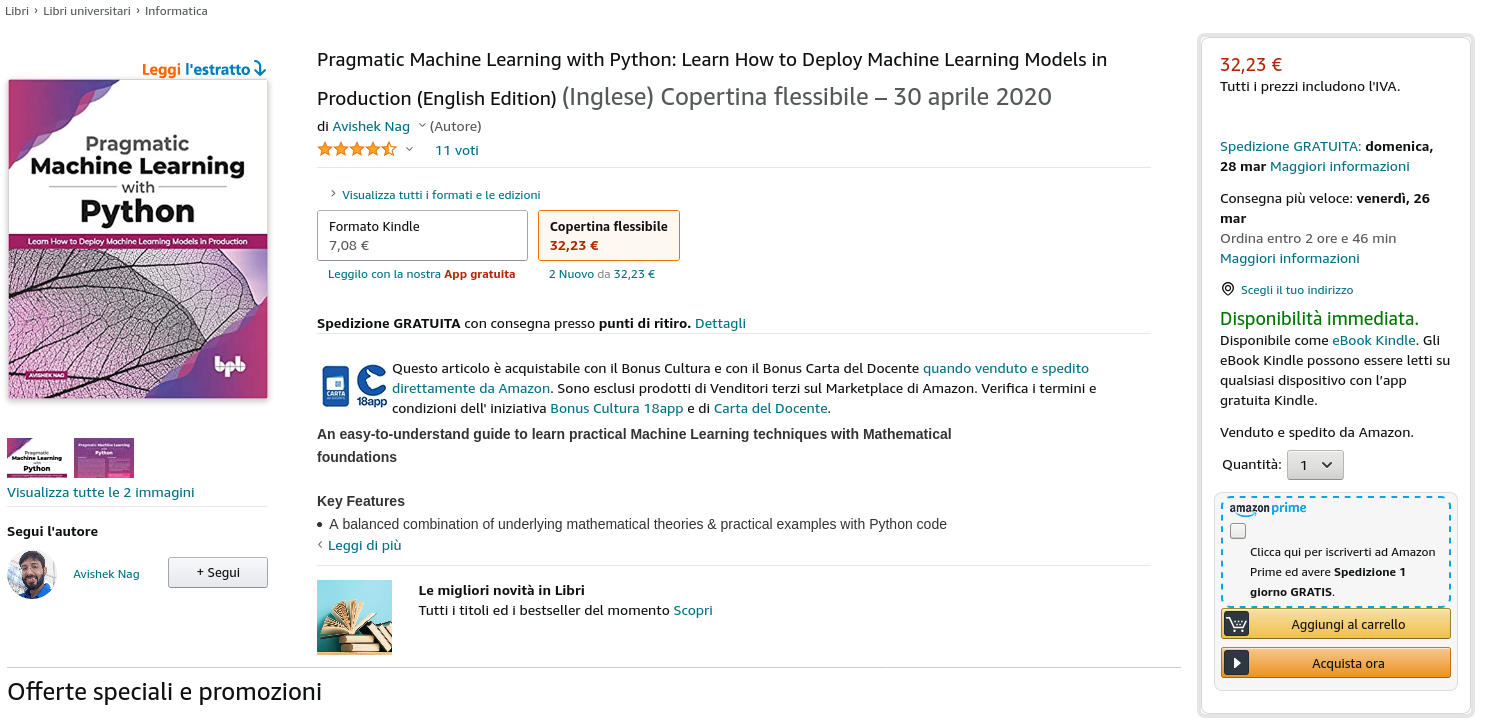

<h3>Notice the book does not have the selected reviews from Amazon</h3>

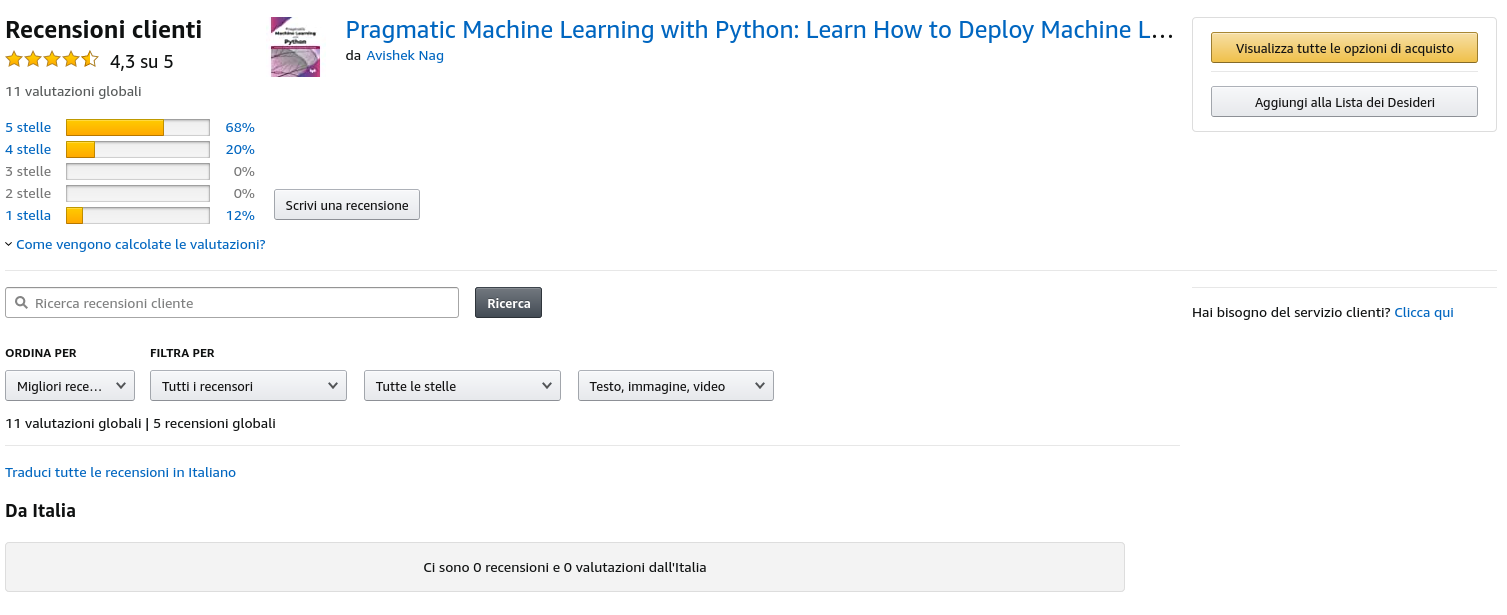

<h3>[First Review with 5 Stars Reating]:</h3>

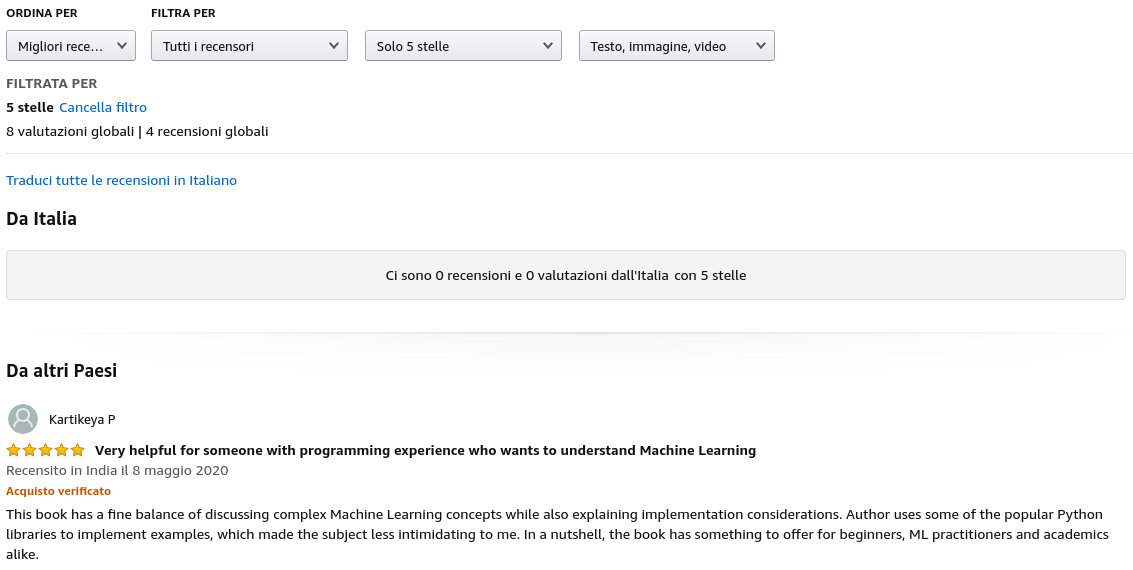

<h3>[First Review with 4 Stars Reating]:</h3>

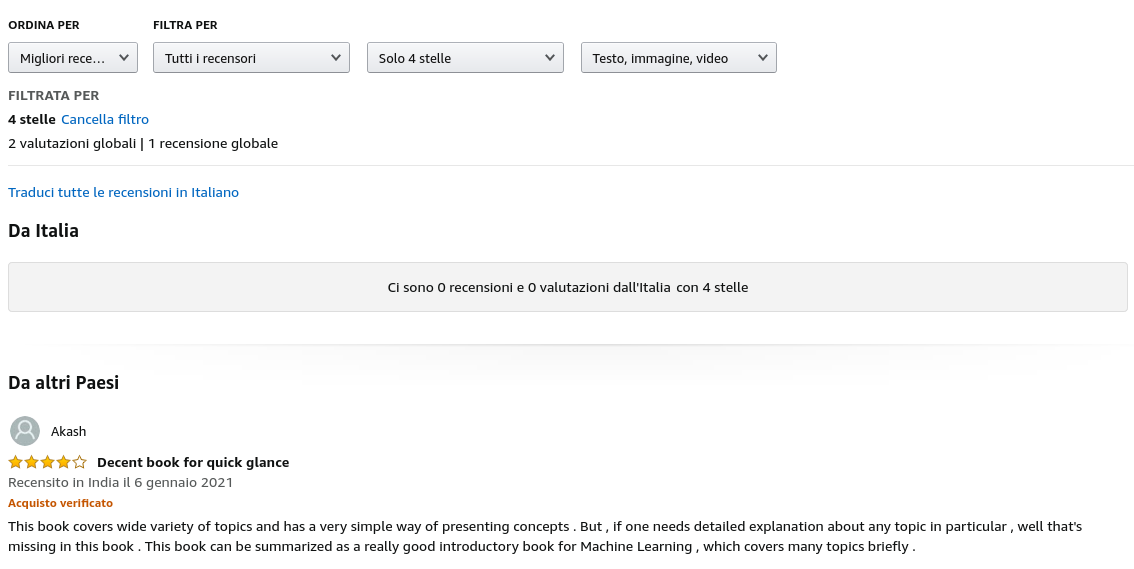

<h3>[There are no reviews with 3 Stars Reating]:</h3>

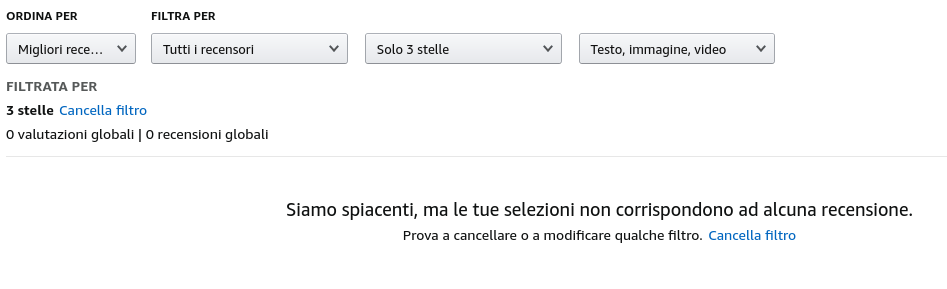

<h3>[There are no reviews with 2 Stars Reating]:</h3>

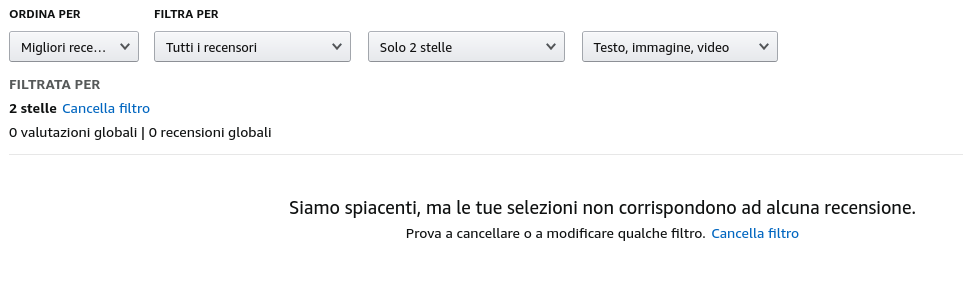

<h3>[There are no reviews with 1 Star Reating]:</h3>

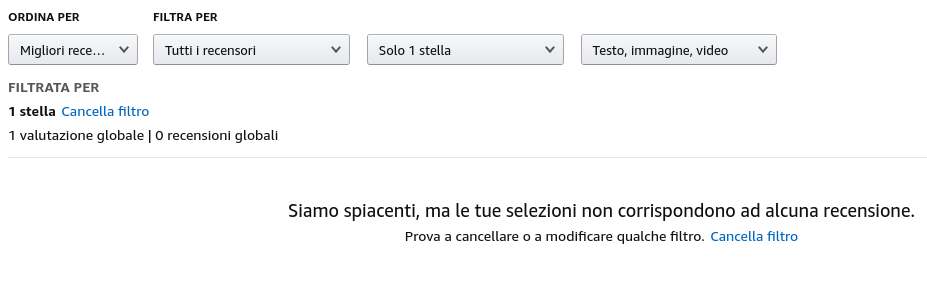